### Решение задачи классификации, где в качестве целевой функции выступает графа "доход" (revenue)
Классификатор должен определить, будет ли от определенного пользователя, кликнувшего рекламу, доход (revenue=1), или нет (revenue=0).
В качестве классификатора используется случайный лес (random forest).

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [9]:
from category_encoders.binary import BinaryEncoder

In [3]:
# Загрузка выборки
dataset = pd.read_csv('dataset_class.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163661 entries, 0 to 163660
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   bannerSize      163661 non-null  object 
 1   language        163661 non-null  object 
 2   country         163661 non-null  object 
 3   city            163661 non-null  object 
 4   browser         163661 non-null  object 
 5   browserVersion  163661 non-null  float64
 6   os              163661 non-null  object 
 7   osVersion       163661 non-null  object 
 8   deviceType      163661 non-null  object 
 9   deviceModel     163661 non-null  object 
 10  deviceBrand     163661 non-null  object 
 11  trafficSource   163661 non-null  int64  
 12  offer           163661 non-null  int64  
 13  connType        163661 non-null  object 
 14  proxyType       163661 non-null  object 
 15  revenue         163661 non-null  int64  
 16  weekday         163661 non-null  int64  
 17  hour      

In [4]:
# Выбор нужных колонок для массива признаков (features)
# и их кодирование при помощи BinaryEncoder
X = dataset.drop(['revenue'], axis=1)
ce_bin = BinaryEncoder(cols = X.columns)
X = ce_bin.fit_transform(X)

c:\users\owl\appdata\local\programs\python\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [5]:
# Переменные отклика (target)
y = dataset.revenue

In [6]:
# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### Random forest

In [49]:
# Определение модели и гиперпараметров 
rf = RandomForestClassifier()
parametrs = {'n_estimators': range(20, 80, 10), 'max_depth': range(6,13, 2),
            'min_samples_leaf': range(1,7), 'min_samples_split': range(2,10, 2)}

In [50]:
# Создание экземпляра RandomizedSearch (/GridSearch)
search = RandomizedSearchCV(rf, parametrs, n_iter=20, cv = 3, n_jobs=-1)
# search = GridSearchCV(rf, parametrs, cv = 3, n_jobs=-1)

In [51]:
# Обучение
search.fit(X, y)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(6, 13, 2),
                                        'min_samples_leaf': range(1, 7),
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(20, 80, 10)})

In [52]:
best_clf_rf = search.best_estimator_
best_clf_rf

RandomForestClassifier(max_depth=8, min_samples_leaf=3, n_estimators=50)

In [53]:
# Предсказанные значения для тестовой выборки
predictions = best_clf_rf.predict(X_test)

Оценка качества работы модели на основании показателей precision и recall (полученные значения: 0.971 и 0.978)

In [54]:
precision_score(y_test, predictions, average='weighted')

0.9708824117851402

In [56]:
recall_score(y_test, predictions, average='weighted')

0.9777348714439339

In [63]:
# Предсказание вероятности относения к классу
y_predict_prob = best_clf_rf.predict_proba(X_test)

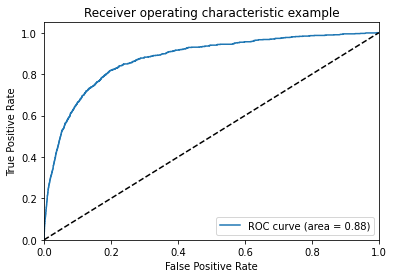

In [64]:
# Отрисовка ROC-кривой
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],  'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [82]:
# Изменение границы вероятности, при которой относим пользователя 
# к определенному классу
y_pred = np.where(y_predict_prob[:, 1] > 0.8, 1, 0)

In [83]:
precision_score(y_test, y_pred, average='weighted')

c:\users\owl\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.955726532271191

In [84]:
recall_score(y_test, y_pred, average='weighted')

0.9776126698602013

Изменение порогового значения не дало существенных улучшений ни для одного из параметров

#### XGBoost

In [13]:
xgb_class = xgb.XGBClassifier()
parameters = {'n_estimators': [200, 300, 400, 500],
             'max_depth': [6, 8, 10],
             'learning_rate':[0.03, 0.07, 0.1],
             'reg_alpha': [0, 2, 5],
             'reg_lambda': [1, 2]
             }

In [14]:
search = RandomizedSearchCV(xgb_class, parameters, n_iter=50, cv = 3, n_jobs=-1)

In [15]:
search.fit(X_train, y_train)

c:\users\owl\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                          

In [16]:
best_clf_xgb = search.best_estimator_
best_clf_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=2, reg_lambda=2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
predictions = best_clf_xgb.predict(X_test)

In [18]:
precision_score(y_test, predictions, average='weighted')

0.9724093161070995

In [19]:
recall_score(y_test, predictions, average='weighted')

0.9777104311271874

Результат почти не отличается от того, который был получен при использовании Random Forest (немного выше значение показателя precision)